In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np


import os, sys
sys.path.insert(0,'..')

from collections import deque 

from dfibert.tracker.nn.rl import Agent, Action_Scheduler, DQN
import dfibert.envs.RLtractEnvironment as RLTe
from dfibert.envs._state import TractographyState

In [2]:
# Test on Lunar Lander to check functionality of agent
#env = gym.make('LunarLander-v2')
#n_actions= env.action_space.n

In [2]:
max_steps = 30000000
replay_memory_size = 60000
agent_history_length = 1
evaluate_every = 200000
eval_runs = 5#20
network_update_every = 10000
start_learning = 20000
eps_annealing_steps = 10000000

max_episode_length = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64
learning_rate = 0.0000000625
#batch_size = 512
#learning_rate = 0.001

In [3]:
env = RLTe.RLtractEnvironment(stepWidth=0.3, action_space=20, device = 'cpu')
#env = RLTe.RLtractEnvironment(stepWidth=0.3, action_space=20, device = 'cpu', pReferenceStreamlines='data/HCP307200_DTI_min40.vtk')
n_actions = env.action_space.n

Loading precomputed streamlines (data/HCP307200_DTI_smallSet.vtk) for ID 100307


In [4]:
state = env.reset()
print(state.shape)
#print(state.getValue().flatten().shape)

(2700,)


In [15]:
# Debugging the optimization of the agent

#state = env.reset()
#state = torch.tensor([state]).to(device).float()
transition = init_transition()
state = torch.FloatTensor([np.array(transition)]).to(device)
print(state.shape)
print(agent.main_dqn(state))
print(agent.target_dqn(state))

action = 1

next_state, reward, done = env.step(action)
print(next_state, reward, done)

action = torch.tensor([action]).to(device)
#next_state = torch.tensor([next_state]).float().to(device)
next_state = add_to_transition(next_state, transition)
next_state = torch.FloatTensor([np.array(next_state)]).to(device)
reward = torch.tensor([reward]).float().to(device)
done = torch.BoolTensor([done]).to(device)
state_action_values = agent.main_dqn(state)
print(state_action_values)
state_action_values = state_action_values[0][action]
print(state_action_values)

next_state_actions = agent.main_dqn(next_state).max(1)[1]
print("Argmax actions: ", next_state_actions)
next_state_values = agent.target_dqn(next_state)[0][next_state_actions]
print(next_state_values)
next_state_values[done] = 0.0
print(next_state_values)
expected_state_action_values = next_state_values.detach() * 0.99 + reward
print(expected_state_action_values)

agent.optimizer.zero_grad()
loss = torch.nn.SmoothL1Loss()(state_action_values, expected_state_action_values)
print(loss)
loss.backward()
agent.optimizer.step()

print(agent.main_dqn(state))
print(agent.target_dqn(state))

torch.Size([1, 12])
tensor([[ 61.8814,  53.5273,  65.1122,  59.5295,  63.2473,  63.3582,  49.6618,
          57.5226,  56.9831,  61.0424,  49.2360,  45.0796,  60.3465,  55.7477,
          60.6391,  54.9909,  55.8694,  60.2220,  35.0820,  47.0737,  53.0218,
          56.9755,  60.0529,  32.3047,  20.4098,  58.4533,  59.7584,  63.0841,
          54.4836,  43.6310,  57.3373,  22.6192,  32.9992,  61.3936,  32.4899,
          60.6012,   8.0376,  39.1546,  58.7364,  28.7151,  25.3395,  59.5876,
          13.1139,  54.3735,  25.8479,  10.7677,  54.2027,  11.2558,  38.6437,
          60.1825,  22.2333,  24.1235,   8.7726,  27.5614,   2.9120,  12.3545,
          26.7937,  17.6043,  34.9672, -12.4343,  23.0219,  27.1385, -15.7887,
          61.7124,  42.1585,  20.3453,  24.3167,  -4.8190,  43.8532,  45.2633,
          13.3825,  64.5126,   0.7540,  17.9066,  45.4248,  -8.3953,  60.9557,
          51.1121,  22.9783,  49.9606,   8.7290,   3.0979,  55.1753,  -3.8223,
          64.8611,  28.4904,  43

In [4]:
state = env.reset(streamline_index=0)
#env.stepCounter += 1
#state = env.state = TractographyState(env.referenceStreamline_ijk[1], env.interpolateDWIatState)
best_actions = []
    #path_vectors = []
    #reference_vectors = []
    #cosine_sims = []
    #distances = []
rewards = []
all_states = []
all_states.append(state.getCoordinate())
for i in range(n_actions):
    #print(state.getCoordinate(), env.state.getCoordinate())
    #print(env.stepCounter)
    next_state, reward,_ = env.step(i)
    all_states.append(next_state.getCoordinate())
    all_states.append(state.getCoordinate())
    rewards.append(reward)
    #print(reward)
    best_actions.append(reward)
    env.state = state
    env.stepCounter -= 1
best_action= torch.argmax(torch.tensor(best_actions))
#return best_action, rewards[best_action]
print(best_action, float(rewards[best_action]))
#print(np.argmin(rewards))


tensor(8) 0.946156463865072


In [7]:
#cos = torch.nn.CosineSimilarity(dim=0)

def get_best_action(state, env):
    best_actions = []
    #path_vectors = []
    #reference_vectors = []
    #cosine_sims = []
    #distances = []
    rewards = []
    for i in range(n_actions):
        #print(state.getCoordinate(), env.state.getCoordinate())
        #print(env.stepCounter)
        next_state, reward,_ = env.step(i)
        #print(env.stepCounter)
        #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
        #print(current_index)
        #path_vector = next_state.getCoordinate() - state.getCoordinate().squeeze(0)
        #print(path_vector)
        #path_vectors.append(path_vector.numpy())
        #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
        #print(reference_vector)
        #reference_vectors.append(reference_vector.numpy())
        #cosine_sim = cos(path_vector, reference_vector)
        #cosine_sims.append(cosine_sim.item())
        #print(cosine_sim)
        #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
        #dist = torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
        #reward = -dist
        #if dist < 0.1:
        #    dist = 0
        #else:
        #    dist = dist - 0.1
        #print(dist)
        #distances.append(dist.item())

        #reward = cosine_sim - dist
        #reward = cosine_sim
        rewards.append(float(reward))
        #print(reward)
        best_actions.append(reward)
        env.state = state
        if reward > 0.:
            env.points_visited -= 1

    #best_actions = torch.topk(torch.tensor(best_actions), k=1)[1].numpy()
    #rewards = np.array(rewards)
    #print(rewards)
    #random_action = np.random.choice(best_actions, size=1)
    best_action= torch.argmax(torch.tensor(best_actions))
    return best_action, rewards[best_action]#random_action
    #return best_actions, rewards[best_actions]

In [7]:
state = env.reset(streamline_index=0)
all_top_actions = []
all_top_rewards = []
terminal = False
while terminal != True:
    best_actions, best_rewards = get_best_action(state, env)
    all_top_actions.append(best_actions)
    all_top_rewards.append(best_rewards)
    next_state, reward, terminal = env.step(best_actions)
    state = next_state

for i in range(len(all_top_actions)):
    print(all_top_actions[i], all_top_rewards[i])
print(len(all_top_actions))

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
tensor(18) -0.2865769195878034
tensor(18) -1.1273370195790775
tensor(4) -2.424969011591129
tensor(4) -4.327222007436952
tensor(4) -6.777214026147034
tensor(4) -9.665246345445938
tensor(4) -13.090876833989244
tensor(4) -17.05380397691169
tensor(4) -21.593030420993262
tensor(4) -26.70859114095503
tensor(4) -32.11113371158046
tensor(4) -37.69221087563927
tensor(4) -43.42913241016327
tensor(4) -49.111353434914136
tensor(4) -54.45451799569919
tensor(4) -59.865602435042135
tensor(4) -65.30202171007204
tensor(4) -71.34217778234071
tensor(4) -77.98627424455486
tensor(4) -84.1211954182125
tensor(4) -90.91450359572941
tensor(4) -97.11175094421695
tensor(4) -104.03667587087153
tensor(4) -111.6893065411703
tensor(4) -117.39905998549301
tensor(4) -122.2724205712021
tensor(12) -121.93260537585766
tensor(12) -120.37258705368836
tensor(12) -117.62987168662849
tensor(12) -115.66194665676696
tensor(12) -114.7457317

In [ ]:
### Transfer learning

In [6]:
#### Fill replay memory with perfect actions for supervised approach

from tqdm import trange
state = env.reset().getValue()
agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)

overall_runs = 0
overall_reward = []
for overall_runs in trange(15):
    state = env.reset(streamline_index=overall_runs)
    #episode_step_counter = 0
    episode_reward = 0
    terminal = False
    #print("New run")
    #print(env.stepCounter, state.getCoordinate().numpy())
    for i in range(1000):#while not terminal:
        #print(env.stepCounter)
        #if np.random.rand(1) < 0.1: 
        #    action = np.random.randint(0, n_actions)
        #else:
        action, _ = get_best_action(state,env)
        next_state, reward, terminal = env.step(action)
        
        #terminal = False

        #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
        #path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
        #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
        #    #print(path_vector, reference_vector)
        #cosine_sim = cos(path_vector, reference_vector)
        #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
        #if dist > 3*0.81:
        #    env.stepCounter -= 1
        #if dist < 0.1:
        #    dist = 0
        #else:
        #    dist = dist - 0.1
        #reward = cosine_sim - dist
        #reward_old = 1 - (optimal_reward - reward)
        #print(env.stepCounter, next_state.getCoordinate().numpy(), reward, reward_old, terminal)
        #if action == 100 and dist==0:
        #    terminal = True

        #if env.stepCounter == 200:
        #    terminal = True
        #dist = torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
        
        #reward = 0.
            #positive_run += 1 
        #if dist > 2.:
        #    reward = -1.
        #    #print("Got negative reward at step ", i)

        #if dist > 0.25:
        #    env.stepCounter -= 1
        #    #if dist < dist_past:
        #    #    reward = 0.5
        #else:
        #    #print("Reached referencePoint at step", i)
        #    reward = 1.
            
        agent.replay_memory.add_experience(action=action,
                                state = state.getValue(),
                                reward=reward,
                                new_state = next_state.getValue(),
                                terminal=terminal)
        
        episode_reward += reward
        
        state = next_state
        
        if terminal == True:
            break
            
    overall_runs += 1
    overall_reward.append(episode_reward)
    print(overall_runs, np.mean(overall_reward[-100:]))
print("Replay memory ready")

  7%|▋         | 1/15 [00:29<06:46, 29.07s/it]

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
1 60.0


 13%|█▎        | 2/15 [01:06<06:50, 31.56s/it]

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
2 65.5


 20%|██        | 3/15 [01:51<07:05, 35.49s/it]

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
3 73.66666666666667


 27%|██▋       | 4/15 [02:38<07:10, 39.17s/it]

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
4 83.5


 33%|███▎      | 5/15 [03:10<06:09, 36.99s/it]

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
5 81.6


 40%|████      | 6/15 [05:24<09:52, 65.88s/it]

6 76.16666666666667


 47%|████▋     | 7/15 [05:40<06:49, 51.15s/it]

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
7 70.28571428571429


 53%|█████▎    | 8/15 [05:55<04:41, 40.17s/it]

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
8 65.375


 60%|██████    | 9/15 [06:42<04:13, 42.22s/it]

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
9 67.33333333333333


 67%|██████▋   | 10/15 [08:22<04:58, 59.69s/it]

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
10 78.9


 73%|███████▎  | 11/15 [08:54<03:25, 51.34s/it]

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
11 77.18181818181819


 80%|████████  | 12/15 [09:06<01:58, 39.50s/it]

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
12 73.0


 87%|████████▋ | 13/15 [09:18<01:02, 31.16s/it]

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
13 69.15384615384616


 93%|█████████▎| 14/15 [09:41<00:28, 28.80s/it]

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
14 67.57142857142857


100%|██████████| 15/15 [11:04<00:00, 44.32s/it]

Defi stopped at/close to the terminal state!
Defi stopped at/close to the terminal state!
15 75.2
Replay memory ready


In [14]:
#save memory
import h5py
hf = h5py.File('memory.hdf5', 'w')
hf.create_dataset('states', data=agent.replay_memory.states[:agent.replay_memory.count])
hf.create_dataset('new_states', data=agent.replay_memory.new_states[:agent.replay_memory.count])
hf.create_dataset('actions', data=agent.replay_memory.actions[:agent.replay_memory.count])
hf.create_dataset('rewards', data=agent.replay_memory.rewards[:agent.replay_memory.count])
hf.create_dataset('terminals', data=agent.replay_memory.terminal_flags[:agent.replay_memory.count])
hf.close()


In [3]:
#load memory
#state = #env.reset().getValue()
agent_learn = Agent(n_actions=20, inp_size=(642, 3, 3, 3), device=device, hidden=10, gamma=0.95, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)
hf = h5py.File('memory.hdf5', 'r')
agent_learn.replay_memory.states = np.array(hf["states"][:60000])
agent_learn.replay_memory.new_states = np.array(hf["new_states"][:60000])
agent_learn.replay_memory.actions = np.array(hf["actions"][:60000])
agent_learn.replay_memory.rewards = np.array(hf["rewards"][:60000])
agent_learn.replay_memory.terminal_flags = np.array(hf["terminals"][:60000])
hf.close()

In [ ]:
print(agent_learn.replay_memory.states.shape)

In [6]:
agent_learn.replay_memory.count = 60000

In [4]:
agent_learn = Agent(n_actions=101, inp_size=(100, 3, 3, 3), device=device, hidden=10, gamma=0.95, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)
hf = h5py.File('memory.hdf5', 'r')
agent_learn.replay_memory.states = np.array(hf["states"][:])
agent_learn.replay_memory.new_states = np.array(hf["next_states"][:])
agent_learn.replay_memory.actions = np.array(hf["actions"][:])
agent_learn.replay_memory.rewards = np.array(hf["rewards"][:])
agent_learn.replay_memory.terminal_flags = np.array(hf["terminal_flags"][:])
print(agent_learn.replay_memory.states.shape)

(30000, 100, 3, 3, 3)


In [5]:
agent_learn.replay_memory.count = 30000

In [79]:
agent.optimizer = torch.optim.Adam(agent.main_dqn.parameters(), 0.00001)

In [ ]:
##### DQN algorithm on perfect memory  ---> failure

#for i in range(200):
#state = env.reset().getValue()
#agent_learn = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.95, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)
#agent_learn.replay_memory.count = 300000
#agent_learn.replay_memory.current = 300000
losses_q = []

for i in trange(200000):
    
    states, actions, rewards, new_states, terminal_flags = agent.replay_memory.get_minibatch()

    states = torch.FloatTensor(states).to(agent.device)
    next_states = torch.FloatTensor(new_states).to(agent.device)
    rewards = torch.FloatTensor(rewards).to(agent.device)
    terminal_flags = torch.BoolTensor(terminal_flags).to(agent.device)

    arg_q_max = torch.argmax(agent.main_dqn(next_states), dim=1).detach()
    #print(arg_q_max.shape)
    q_vals = agent_learn.target_dqn(next_states).detach()
    #print(q_vals.shape)
    double_q = q_vals[range(agent_learn.batch_size), arg_q_max].detach()

    target_q = rewards + (agent_learn.gamma * double_q * ~terminal_flags).detach()

    current_qs = agent_learn.main_dqn(states)
    #print(current_qs)
    #print(current_qs)
    #print(actions)
    predict_q = torch.sum(torch.mul(current_qs, torch.nn.functional.one_hot(actions)), dim=1)
    #print(predict_q)
    #print(predict_q)
    #print(predict_q.shape)

    loss = torch.nn.functional.smooth_l1_loss(predict_q, target_q)
    losses_q.append(loss.item())
    agent_learn.optimizer.zero_grad()
    loss.backward()
    agent_learn.optimizer.step()
    #if i % 20 == 0:
    #    print(i, loss.item())
    
    if i % 10000 == 0:
        #print("Target update")
        agent_learn.target_dqn.load_state_dict(agent_learn.main_dqn.state_dict())



In [62]:
#### Supervised learning on perfect memory --> worked

state = env.reset().getValue()
agent_learn = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=64, learning_rate=0.00001)
#losses = []
for i in trange(5000):
    states, actions, _, _, _ = agent.replay_memory.get_minibatch()

    states = torch.FloatTensor(states).to(agent.device)
    actions = torch.LongTensor(actions).to(agent.device)

    predicted_q = agent.main_dqn(states)
    loss = torch.nn.functional.cross_entropy(predicted_q, actions)
    #print(loss.item())
    agent.optimizer.zero_grad()
    loss.backward()
    agent.optimizer.step()
    losses.append(loss.item())

100%|██████████| 5000/5000 [03:34<00:00, 23.33it/s]


In [49]:
mean_losses = []
for i in range(len(losses)):
    mean_losses.append(np.mean(losses[i:i+99]))
print(mean_losses[-20:])

[1.018749761581421, 1.0191968930395026, 1.025349626938502, 1.016963871086345, 1.0223832726478577, 1.025348917643229, 1.0346278590815408, 1.0429766911726732, 1.0506814817587535, 1.0534005165100098, 1.0564554810523987, 1.0451937516530354, 1.0505777895450592, 1.0427804674421037, 1.0287232995033264, 1.0309260368347168, 1.03744238615036, 1.0651545127232869, 1.0329301953315735, 0.9399116039276123]


<IPython.core.display.Javascript object>


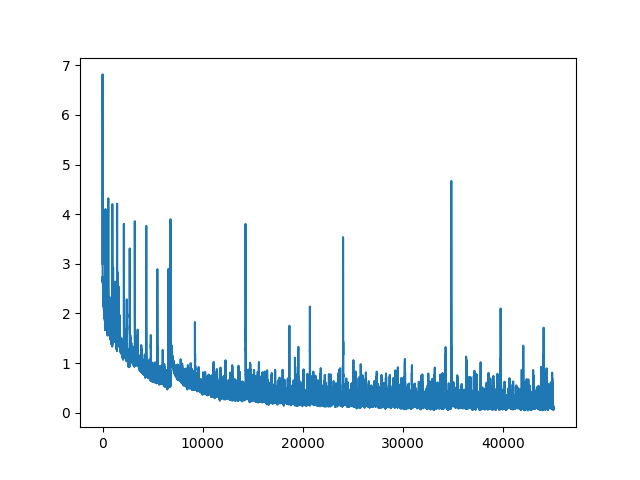

In [63]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(len(losses[:])), losses[:])
#ax.plot(range(len(losses[:])), mean_losses[:])
plt.show()

In [71]:
agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())

<All keys matched successfully>

In [74]:
states, actions, _, _, _ = agent.replay_memory.get_minibatch()
states = torch.FloatTensor(states).to(agent.device)
predicted_q = torch.argmax(agent.main_dqn(states), dim=1)

false = 0
for i in range(len(actions)):
    if predicted_q[i] != actions[i]:
        false += 1 
    
print("Accuracy =", 1 - false / len(actions))

Accuracy = 0.955078125


In [ ]:
#### test performance of pretrained agent

state = env.reset(streamline_index=0)
terminal = False
all_states = []
all_states.append(state.getCoordinate())

while not terminal:
    action, optimal_reward  = get_best_action(state, env)
    #if np.random.rand(1) < .5: 
    #    action = np.random.randint(0, n_actions)
    #print("Action:", action)
    next_state, reward, terminal = env.step(action)
    #print("Step counter: ", env.stepCounter)
    current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
    #print("Current index: ", current_index)
    #print("state.getCoordinate(): ", state.getCoordinate().numpy())
    #print("env.state.getCoordinate(): ", env.state.getCoordinate().numpy())
    #print("next_state.getCoordinate(): ", next_state.getCoordinate().numpy())
    #path_vector = next_state.getCoordinate() - state.getCoordinate().squeeze(0)
    #print("path vector: ", path_vector)
    #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
    #print("reference_vector: ", reference_vector)
    #cosine_sim = F.cosine_similarity(path_vector, reference_vector, dim=0)
    #print("cosine_sim: ", cosine_sim)
    #dist = torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)#torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
    #dist_past = torch.dist(env.referenceStreamline_ijk[current_index], state.getCoordinate(), p=2)
    #if dist > 0.3:
    #    env.stepCounter -= 1
    #reward = 0.
    #    #positive_run += 1 
    #if dist > 2.:
    #    reward = -1.

    #if dist > 0.26:
    #    env.stepCounter -= 1
        #if dist < dist_past:
        #    reward = 0.5
    #else:
    #    reward = 1.
    #print("distance: ", dist)
    all_states.append(next_state.getCoordinate())
    state = next_state
    print(env.stepCounter, action, reward, dist)#cosine_sim.item(), dist.item(), 1-(optimal_reward-(cosine_sim-dist)))
    #if action == 100 and 1-(optimal_reward-(cosine_sim-dist)) == 1:
    #    terminal = True
    #else:
    #    terminal = False

In [26]:
len(all_states)

157

In [6]:
state = env.reset().getValue()
agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)

In [9]:
agent.main_dqn.load_state_dict(torch.load("defi_pretrained_95pacc.pth"))
agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())

<All keys matched successfully>

In [10]:
print(state.shape)
print(agent.main_dqn)

(642, 3, 3, 3)
DQN(
  (linear_layers): ModuleList(
    (0): Linear(in_features=17334, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): Linear(in_features=1024, out_features=1024, bias=True)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): Linear(in_features=1024, out_features=1024, bias=True)
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): Linear(in_features=1024, out_features=20, bias=True)
  )
)


In [ ]:
#### DQN training

#uncomment next 2 lines for regular DQN trainig without pretrained network
#state = env.reset().getValue()
#agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.95, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

#transition = init_transition()
#agent = Agent(n_actions=n_actions, inp_size=np.array(transition).shape, device=device, hidden=10, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)
action_scheduler = Action_Scheduler(num_actions=n_actions, max_steps=max_steps, eps_initial=0.5, eps_annealing_steps=eps_annealing_steps, eps_final=0.1, eps_final_step=0.02, replay_memory_start_size=start_learning, model=agent.main_dqn)

step_counter = 0

eps_rewards = []

episode_lengths = []

cos = torch.nn.CosineSimilarity(dim=0)

print("Start training...")
while step_counter < max_steps:
    epoch_step = 0
    #agent.main_dqn.train()
######## fill memory begins here
    while (epoch_step < evaluate_every) or (step_counter < start_learning):
        state = env.reset()
        env.stepCounter = np.random.randint(len(env.referenceStreamline_ijk)-10)
        env.state = TractographyState(env.referenceStreamline_ijk[env.stepCounter], env.interpolateDWIatState)
        #transition = init_transition()
        #referenceLine = env.referenceStreamline_ijk
        episode_reward_sum = 0
        terminal = False
        #fill replay memory while interacting with env
        #for episode_counter in range(max_episode_length):
        episode_step_counter = 0
        positive_run = 0
        points_visited = 0
        
        dist = 0
        #influential_action = None
        while not terminal:
            # get action with epsilon-greedy strategy
            #if dist < 0.1:
            #_, optimal_reward = get_best_action(state, env)
               #print(influential_action)
            #else:
            #    influential_action = None
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)) #influential_action=influential_action)
            #action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device))
            #print("Before step: ", env.stepCounter)
            
            next_state, reward, terminal = env.step(action)
            episode_step_counter += 1
            #print(episode_step_counter, action, reward, optimal_reward, torch.tanh(1-(optimal_reward - reward)))
            #print("After step: ", env.stepCounter)
            
            #if reward < -1.:
            #    reward = -1.
            
            #terminal = False
            
            #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
            #path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
            #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
            ##    #print(path_vector, reference_vector)
            #cosine_sim = cos(path_vector, reference_vector)
            #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
            #reward = -torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
            #if reward == 0.:
            #    reward = 1.
            
            #if reward < -0.05:
            #    env.stepCounter -= 1
            
            #reward = torch.tanh(1- (optimal_reward - reward))
            #if reward >= 0.76:
            #    reward = 1.
            #elif reward < 0.:
            #    reward = -1.
            #else:
            #    reward = 0.
            current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
            dist = torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
            dist_past = torch.dist(env.referenceStreamline_ijk[current_index], state.getCoordinate(), p=2)
            #if dist <= 0.09:
            #    reward = 1.
            #elif dist < 0.25:
            #    reward = 0.5
            #elif dist < 1.:
            #    reward = 0.25
            #elif dist_past < dist:
            #    reward = -1
            #    #env.stepCounter -= 1
            #else:
            #    reward = 0.
                #env.stepCounter -= 1
            
            #if action == 19:
            #    if dist <= 0.09:
            #        reward = 1.
            #    else:
            #        reward = -1.
                    
            #if reward > 0.:
            #    positive_run += 1
            #print("Before test for dist: ", env.stepCounter, "Dist: ", dist)
            #print("After test for dist: ", env.stepCounter)
            #if dist < dist_past:
            reward = 0.
                #positive_run += 1 
            if dist > 2.:
                reward = -1.
                
            if dist > 0.25:
                env.stepCounter -= 1
                #if dist < dist_past:
                    #reward = 0.5
                    #positive_run += 1
            else:
                points_visited += 1
                reward = 1.
                positive_run += 1
                print("Reached referencePoint {} at step {}".format(points_visited, episode_step_counter))
                #env.stepCounter -= 1
            #if reward < -5.0:
            #    reward = -5.0
            #if reward < -100:
            #    reward = -100
            #if dist < 0.1:
            #    dist = 0
            #else:
            #    dist = dist - 0.1
            #if dist > 3*0.81:
            #    env.stepCounter -= 1
            #reward = cosine_sim - dist
            #reward = 1 - (optimal_reward - reward)
            #reward = 1- (optimal_reward - dist)
            #if reward == optimal_reward:
            #    reward = 1
            #if action == 100 and dist < 0.1:
            #    terminal = True
            #print("From function: ", influential_action, optimal_reward)
            #print("From scheduler: ", action, reward,  terminal)
            #print("Cosine sim: ", cosine_sim)
            #print("Dist: ", dist)
            
            #if episode_step_counter >= 200:
            #    terminal = True
            
            #print(episode_step_counter, action, reward, terminal)
            #print(reward)
            #if dist > 0.7: # cosine_sim < 0.4 or
            #    terminal = True
            #next_state = next_state[:2]
            #next_transition = add_to_transition(next_state, transition)
            
            step_counter += 1
            epoch_step += 1

            # accumulate reward for current episode
            episode_reward_sum += reward


            agent.replay_memory.add_experience(action=action,
                                #state=np.array(transition),
                                state = state.getValue(),
                                reward=reward,
                                #new_state=np.array(next_transition),
                                new_state = next_state.getValue(),
                                terminal=terminal)


            state = next_state
            #transition = next_transition



            ####### optimization is happening here
            if step_counter > start_learning and step_counter % 4 == 0:
                #if reward > 0.:
                #    print("reward was positive: ", reward)
                loss = agent.optimize()


            ####### target network update
            if step_counter > start_learning and step_counter % network_update_every == 0:
                #print("Update net")
                #print(agent.main_dqn(torch.tensor(state).to(device).unsqueeze(0)))
                #print(agent.target_dqn(torch.tensor(state).to(device).unsqueeze(0)))
                agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())

            # if episode ended before maximum step
            if episode_step_counter >= 1000:
                terminal = True
            if terminal:
                terminal = False
                episode_lengths.append(episode_step_counter)
                #state = env.reset()[:2]
                #transition = init_transition()
                break

        eps_rewards.append(episode_reward_sum)

        if len(eps_rewards) % 1 == 0:
            #with open(path+'/logs/rewards.dat', 'a') as reward_file:
                #print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])), file=reward_file)
            print("{}, done {} episodes, {}, current eps {}".format(step_counter, len(eps_rewards), np.mean(eps_rewards[-100:]), action_scheduler.eps_current), np.mean(episode_lengths[-100:]), positive_run, points_visited)
    #torch.save(agent.main_dqn.state_dict(), path+'/checkpoints/fibre_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eps_rewards[-100:])))

########## evaluation starting here
    eval_rewards = []
    episode_final = 0
    #agent.main_dqn.eval()
    for _ in range(eval_runs):
        eval_steps = 0
        state = env.reset()
        #transition = init_transition()
        #env.state = TractographyState(env.referenceStreamline_ijk[0], env.interpolateDWIatState)
        #env.stepCounter = 0
        
        eval_episode_reward = 0
        while eval_steps < 1000:
            #_, optimal_reward = get_best_action(state, env)
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).unsqueeze(0).to(device), evaluation=True)
            #action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)
            next_state, reward, terminal = env.step(action)
            
            eval_steps += 1
            
            #if reward < -0.05:
            #    env.stepCounter -= 1
            #reward = 1 - (optimal_reward-reward)
            #if reward >= 0.76:
            #    reward = 1
            #elif reward < 0.:
            #    reward = -1.
            #else:
            #    reward = 0.
            current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
            dist = torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
            dist_past = torch.dist(env.referenceStreamline_ijk[current_index], state.getCoordinate(), p=2)
            
            reward = 0.
                #positive_run += 1 
            if dist > 2.:
                reward = -1.
                
            if dist > 0.25:
                env.stepCounter -= 1
                #if dist < dist_past:
                #    reward = 0.5
            else:
                points_visited += 1
                reward = 1.
                positive_run += 1
        
            #if dist < dist_past:
            #    reward = 1.
            #else:
            #    reward = -1.
            #    
            #if dist > 0.1:
            #    env.stepCounter -= 1
            #else:
            #    reward += 4    
            
            #if dist <= 0.09:
            #    reward = 1.
            #elif dist < 0.25:
            #    reward = 0.5
            #elif dist < 1.:
            #    reward = 0.25
            #elif dist_past < dist:
            #    reward = -1
                #env.stepCounter -= 1
            #else:
            #    reward = 0.
                #env.stepCounter -= 1
            
            #if action == 19:
            #    if dist <= 0.09:
            #        reward = 1.
            #    else:
            #        reward = -1.
                    
            #if reward != 1.:
            #    env.stepCounter -= 1
    

            
            #if reward < -5.0:
            #    reward = -5.0
            #if reward < -100:
            #    reward = -100

            #if reward < -1.:
            #    reward = -1.
            #terminal = False
            #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
            #path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
            #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
            #    #print(path_vector, reference_vector)
            #cosine_sim = cos(path_vector, reference_vector)
            #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2)
            #if dist < 0.1:
            #    dist = 0
            #else:
            #    dist = dist - 0.1
            #if dist > 3*0.81:
            #    env.stepCounter -= 1
            #reward = cosine_sim - dist
            #reward = 1- (optimal_reward - reward)
            #if reward == optimal_reward:
            #    reward = 1
            #if action == 100 and env.rewardForTerminalState(next_state) < 0.1:
            #    terminal = True

            #if episode_step_counter == 200:
            #    terminal = True
            
            #if cosine_sim < 0.9:
            #    terminal = True
            
            eval_episode_reward += reward
            state = next_state
            #transition = next_transition
            if terminal:
                terminal = False
                if reward == 1.:
                    print(reward)
                    episode_final += 1
                break

        eval_rewards.append(eval_episode_reward)

    print("Evaluation score:", np.mean(eval_rewards))
    print("{} of {} episodes ended close to / at the final state.".format(episode_final, eval_runs))
    #if np.mean(eval_rewards) > 500.:
    #torch.save(agent.main_dqn.state_dict(), 'checkpoints/defi_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eval_rewards)))

Start training...
1000, done 1 episodes, -988.0, current eps 0.5 1000.0 0 0
2000, done 2 episodes, -986.5, current eps 0.5 1000.0 0 0
3000, done 3 episodes, -965.3333333333334, current eps 0.5 1000.0 0 0
4000, done 4 episodes, -967.75, current eps 0.5 1000.0 0 0
5000, done 5 episodes, -969.4, current eps 0.5 1000.0 0 0
6000, done 6 episodes, -972.3333333333334, current eps 0.5 1000.0 0 0
7000, done 7 episodes, -975.1428571428571, current eps 0.5 1000.0 0 0
8000, done 8 episodes, -975.625, current eps 0.5 1000.0 0 0
9000, done 9 episodes, -976.8888888888889, current eps 0.5 1000.0 0 0
10000, done 10 episodes, -978.5, current eps 0.5 1000.0 0 0
11000, done 11 episodes, -975.6363636363636, current eps 0.5 1000.0 0 0
12000, done 12 episodes, -972.1666666666666, current eps 0.5 1000.0 0 0
13000, done 13 episodes, -972.3846153846154, current eps 0.5 1000.0 0 0
14000, done 14 episodes, -973.0, current eps 0.5 1000.0 0 0
15000, done 15 episodes, -974.0, current eps 0.5 1000.0 0 0
16000, done 1

94584, done 95 episodes, -961.3894736842105, current eps 0.49701668000000004 995.6210526315789 0 0
95584, done 96 episodes, -960.6770833333334, current eps 0.49697668 995.6666666666666 0 0
96584, done 97 episodes, -960.9484536082474, current eps 0.49693668 995.7113402061856 0 0
97584, done 98 episodes, -959.0, current eps 0.49689668000000004 995.7551020408164 0 0
98584, done 99 episodes, -958.5858585858585, current eps 0.49685668000000005 995.7979797979798 0 0
99569, done 100 episodes, -958.62, current eps 0.49681728000000003 995.69 0 0
100569, done 101 episodes, -958.38, current eps 0.49677728000000004 995.69 0 0
101569, done 102 episodes, -958.37, current eps 0.49673728 995.69 0 0
102569, done 103 episodes, -958.73, current eps 0.49669728 995.69 0 0
103569, done 104 episodes, -958.77, current eps 0.49665728000000003 995.69 0 0
104569, done 105 episodes, -958.91, current eps 0.49661728000000005 995.69 0 0
105569, done 106 episodes, -959.0, current eps 0.49657728 995.69 0 0
106569, don

In [69]:
torch.save(agent.main_dqn.state_dict(), 'defi_pretrained_95pacc.pth')

In [ ]:
print(path_vector.shape)
print(reference_vector.shape)

In [65]:
state = env.reset()

q_vals = agent.main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device))
print(q_vals[0][80])

tensor(-3.5291, device='cuda:0', grad_fn=<SelectBackward>)


In [9]:
defi = DQN(n_actions=n_actions, input_shape=513).to(device)
action_scheduler = Action_Scheduler(num_actions=n_actions, max_steps=max_steps, eps_annealing_steps=eps_annealing_steps, eps_final=0.1, eps_final_step=0.02, replay_memory_start_size=start_learning, model=defi)

defi.load_state_dict(torch.load('high_gamma/checkpoints/defi_487575_reward_1.00.pth'))
defi.eval()

DQN(
  (linear_layers): ModuleList(
    (0): Linear(in_features=513, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): Linear(in_features=1024, out_features=1024, bias=True)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): Linear(in_features=1024, out_features=1024, bias=True)
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): Linear(in_features=1024, out_features=20, bias=True)
  )
)

In [70]:
agent.main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device))

tensor([[-1.6178e+01, -6.7129e+01, -8.5554e+00,  1.3380e+00,  6.6536e-01,
         -5.0221e+01, -5.4585e+01, -2.7546e+01,  1.1241e-02, -1.0947e+00,
         -6.7149e+01, -6.6872e+01, -2.0995e+01, -2.1689e+01, -2.0622e+01,
         -6.2675e-01, -1.2820e+01, -2.2711e+01, -1.2351e+01,  2.0856e+00]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [66]:
eval_rewards = []
all_distances = []
all_states = []
#agent.main_dqn.eval()
for _ in range(1):
    eval_steps = 0
    state = env.reset(streamline_index=2)    
    #state = env.reset()
    #print(state.getCoordinate())
    all_states.append(state.getCoordinate())
    #transition = init_transition()
    #all_states.append(torch.tensor(list(transition)[:3]))
    eval_episode_reward = 0
    episode_final = 0
    #print(env.referenceStreamline_ijk[:6])
    
    while eval_steps < max_episode_length:
        action = torch.argmax(agent.main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)))
        #action = action_scheduler.get_action(eval_steps, torch.FloatTensor(state.getValue()).unsqueeze(0).to(device), evaluation=True)
        #action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)
        #action = torch.argmax(agent(torch.FloatTensor([np.array(transition)]).to(device)))
        next_state, reward, terminal = env.step(action)
        
        
        #_, optimal_reward = get_best_action(state, env)
        #if reward < -0.05:
        #        env.stepCounter -= 1
        #    
        #reward = torch.tanh(1- (optimal_reward - reward))
        #if reward >= 0.76:
        #    reward = 1.
        #elif reward < 0.1:
        #    reward = -1.
        #else:
        #    reward = 0.
        current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
        dist = torch.dist(env.referenceStreamline_ijk[current_index], next_state.getCoordinate(), p=2)
        dist_past = torch.dist(env.referenceStreamline_ijk[current_index], state.getCoordinate(), p=2)


        reward = 0.
        #positive_run += 1 
        if dist > 2.:
            reward = -1.

        if dist > 0.25:
            env.stepCounter -= 1
            #if dist < dist_past:
            #    reward = 0.5
        else:
            reward = 1.

        #current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
        #path_vector = (next_state.getCoordinate() - state.getCoordinate()).squeeze(0)
        #reference_vector = env.referenceStreamline_ijk[current_index]-env.referenceStreamline_ijk[current_index-1]
        #    #print(path_vector, reference_vector)
        #cosine_sim = cos(path_vector, reference_vector)
        #dist = torch.sum((env.referenceStreamline_ijk[current_index] - next_state.getCoordinate())**2) * 10
        #reward = cosine_sim - dist
        #reward = 1 - (optimal_reward - reward)
        #if dist > 3*0.81:
        #    env.stepCounter -= 1
        #if action == 100 and reward == 1:
        #    terminal = False
            
        #if cosine_sim < 0.7:
        #    terminal = True
        #next_state = next_state
        #next_transition = add_to_transition(next_state, transition)
        #reward = 1 + (1+(reward/10))
        #if reward > 1:
        #    reward = 1
        #elif reward > 0.:
        #    reward = 0
        #else:
        #    reward = -1
        eval_episode_reward += reward
        print(eval_steps, action, next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])].numpy(), reward)
        #print(eval_steps, action, next_state, env.referenceStreamline_ijk[np.min([eval_steps,len(env.referenceStreamline_ijk)-1])].numpy(), reward)
        eval_steps += 1
        if eval_steps == 1000:
            terminal = True
        all_distances.append(reward)
        all_states.append(next_state.getCoordinate())
        #all_states.append(next_state)
        
        state = next_state
        #transition = next_transition
        if terminal:
            terminal = False
            #if reward > 0.9:
            #    episode_final += 1
            break

    eval_rewards.append(eval_episode_reward)

print("Evaluation score:", np.min(eval_rewards))

0 tensor(5, device='cuda:0') [ 63.02686237 128.97458998  42.20553147] [ 63.03587 129.11551  41.94084] 0.0
1 tensor(16, device='cuda:0') [ 62.91126143 128.75853935  42.37861686] [ 62.921745 128.58087   42.524906] 1.0
2 tensor(5, device='cuda:0') [ 62.9022542  128.6176203   42.64330666] [ 62.921745 128.58087   42.524906] 0.0
3 tensor(16, device='cuda:0') [ 62.78665326 128.40156967  42.81639204] [ 62.921745 128.58087   42.524906] 0.0
4 tensor(5, device='cuda:0') [ 62.77764602 128.26065061  43.08108184] [ 62.807625 128.04623   43.10897 ] 1.0
5 tensor(16, device='cuda:0') [ 62.66204509 128.04459999  43.25416722] [ 62.807625 128.04623   43.10897 ] 0.0
6 tensor(16, device='cuda:0') [ 62.54644415 127.82854936  43.42725261] [ 62.807625 128.04623   43.10897 ] 0.0
7 tensor(16, device='cuda:0') [ 62.43084321 127.61249874  43.60033799] [ 62.807625 128.04623   43.10897 ] 0.0
8 tensor(0, device='cuda:0') [ 62.69914601 127.54364138  43.71554333] [ 62.586143 127.418526  43.552746] 1.0
9 tensor(16, devi

75 tensor(12, device='cuda:0') [ 62.93988044 117.00224929  50.09246512] [ 62.96819 116.92916  50.19396] 1.0
76 tensor(13, device='cuda:0') [ 63.09013892 116.89328544  50.32815405] [ 62.96819 116.92916  50.19396] 0.0
77 tensor(12, device='cuda:0') [ 63.05233526 116.74737679  50.06876717] [ 62.96819 116.92916  50.19396] 0.0
78 tensor(13, device='cuda:0') [ 63.20259373 116.63841294  50.30445609] [ 62.96819 116.92916  50.19396] 0.0
79 tensor(12, device='cuda:0') [ 63.16479007 116.4925043   50.04506922] [ 62.96819 116.92916  50.19396] 0.0
80 tensor(13, device='cuda:0') [ 63.31504854 116.38354044  50.28075814] [ 63.294937 116.19909   50.178806] 1.0
81 tensor(0, device='cuda:0') [ 63.58335134 116.31468308  50.39596349] [ 63.294937 116.19909   50.178806] 0.0
82 tensor(12, device='cuda:0') [ 63.54554768 116.16877444  50.13657661] [ 63.294937 116.19909   50.178806] 0.0
83 tensor(0, device='cuda:0') [ 63.81385049 116.09991708  50.25178196] [ 63.294937 116.19909   50.178806] 0.0
84 tensor(12, devi

150 tensor(0, device='cuda:0') [ 72.66465402 109.8939258   56.54608449] [ 72.70192  110.07229   56.623146] 1.0
151 tensor(15, device='cuda:0') [ 72.66743311 110.05735014  56.79764911] [ 72.70192  110.07229   56.623146] 0.0
152 tensor(8, device='cuda:0') [ 72.85381719 110.27294361  56.70394515] [ 72.70192  110.07229   56.623146] 0.0
153 tensor(0, device='cuda:0') [ 73.12211999 110.20408625  56.81915049] [ 72.70192  110.07229   56.623146] 0.0
154 tensor(15, device='cuda:0') [ 73.12489909 110.36751059  57.07071512] [ 73.24691  110.51324   57.008553] 1.0
155 tensor(8, device='cuda:0') [ 73.31128317 110.58310405  56.97701115] [ 73.24691  110.51324   57.008553] 0.0
156 tensor(15, device='cuda:0') [ 73.31406227 110.74652839  57.22857578] [ 73.24691  110.51324   57.008553] 0.0
157 tensor(8, device='cuda:0') [ 73.50044635 110.96212185  57.13487181] [ 73.24691  110.51324   57.008553] 0.0
158 tensor(15, device='cuda:0') [ 73.50322545 111.12554619  57.38643644] [ 73.63614 111.08462  57.41109] 1.0


225 tensor(3, device='cuda:0') [ 81.87243115 120.57823792  47.97607227] [ 81.76491  120.709206  47.8813  ] 1.0
226 tensor(9, device='cuda:0') [ 81.69480106 120.73687464  47.79363888] [ 81.76491  120.709206  47.8813  ] 0.0
227 tensor(3, device='cuda:0') [ 81.74821819 121.01754176  47.70213707] [ 81.76491  120.709206  47.8813  ] 0.0
228 tensor(9, device='cuda:0') [ 81.5705881  121.17617848  47.51970367] [ 81.59361  121.34939   47.433174] 1.0
229 tensor(3, device='cuda:0') [ 81.62400523 121.45684559  47.42820186] [ 81.59361  121.34939   47.433174] 0.0
230 tensor(9, device='cuda:0') [ 81.44637514 121.61548231  47.24576846] [ 81.59361  121.34939   47.433174] 0.0
231 tensor(3, device='cuda:0') [ 81.49979227 121.89614943  47.15426665] [ 81.420975 122.046     47.079712] 1.0
232 tensor(3, device='cuda:0') [ 81.55320939 122.17681654  47.06276484] [ 81.420975 122.046     47.079712] 0.0
233 tensor(9, device='cuda:0') [ 81.37557931 122.33545326  46.88033145] [ 81.420975 122.046     47.079712] 0.0
2

300 tensor(15, device='cuda:0') [ 79.16264739 135.46096392  48.88452892] [ 81.24907  122.78528   46.826893] -1.0
301 tensor(15, device='cuda:0') [ 79.16542649 135.62438826  49.13609355] [ 81.24907  122.78528   46.826893] -1.0
302 tensor(3, device='cuda:0') [ 79.21884361 135.90505537  49.04459173] [ 81.24907  122.78528   46.826893] -1.0
303 tensor(15, device='cuda:0') [ 79.22162271 136.06847971  49.29615636] [ 81.24907  122.78528   46.826893] -1.0
304 tensor(15, device='cuda:0') [ 79.22440181 136.23190405  49.54772099] [ 81.24907  122.78528   46.826893] -1.0
305 tensor(3, device='cuda:0') [ 79.27781894 136.51257117  49.45621918] [ 81.24907  122.78528   46.826893] -1.0
306 tensor(15, device='cuda:0') [ 79.28059803 136.6759955   49.70778381] [ 81.24907  122.78528   46.826893] -1.0
307 tensor(15, device='cuda:0') [ 79.28337713 136.83941984  49.95934844] [ 81.24907  122.78528   46.826893] -1.0
308 tensor(15, device='cuda:0') [ 79.28615623 137.00284418  50.21091306] [ 81.24907  122.78528   4

375 tensor(3, device='cuda:0') [ 82.47551167 137.34410339  55.05967292] [ 81.24907  122.78528   46.826893] -1.0
376 tensor(3, device='cuda:0') [ 82.52892879 137.6247705   54.96817111] [ 81.24907  122.78528   46.826893] -1.0
377 tensor(3, device='cuda:0') [ 82.58234592 137.90543762  54.8766693 ] [ 81.24907  122.78528   46.826893] -1.0
378 tensor(4, device='cuda:0') [ 82.49160438 138.01365476  55.1413484 ] [ 81.24907  122.78528   46.826893] -1.0
379 tensor(12, device='cuda:0') [ 82.45380072 137.86774611  54.88196152] [ 81.24907  122.78528   46.826893] -1.0
380 tensor(3, device='cuda:0') [ 82.50721785 138.14841323  54.79045971] [ 81.24907  122.78528   46.826893] -1.0
381 tensor(4, device='cuda:0') [ 82.41647631 138.25663037  55.05513881] [ 81.24907  122.78528   46.826893] -1.0
382 tensor(3, device='cuda:0') [ 82.46989344 138.53729748  54.963637  ] [ 81.24907  122.78528   46.826893] -1.0
383 tensor(15, device='cuda:0') [ 82.47267254 138.70072182  55.21520163] [ 81.24907  122.78528   46.826

450 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
451 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
452 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
453 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
454 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
455 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
456 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
457 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
458 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

524 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
525 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
526 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
527 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
528 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
529 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
530 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
531 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
532 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

598 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
599 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
600 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
601 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
602 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
603 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
604 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
605 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
606 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

672 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
673 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
674 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
675 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
676 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
677 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
678 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
679 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
680 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

746 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
747 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
748 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
749 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
750 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
751 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
752 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
753 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
754 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

820 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
821 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
822 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
823 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
824 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
825 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
826 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
827 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
828 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

894 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
895 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
896 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
897 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
898 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
899 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
900 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
901 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
902 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

968 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
969 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
970 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
971 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
972 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
973 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
974 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
975 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528   46.826893] -1.0
976 tensor(19, device='cuda:0') [ 83.87784582 141.0842694   52.97485008] [ 81.24907  122.78528  

In [67]:
states, actions, rewards, new_states, terminal_flags = agent.replay_memory.get_minibatch()
print(np.array_equal(states[0], new_states[0]))

False


In [27]:
def sphere_dist(nextState):
    current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
    x_dist = (nextState.getCoordinate()[0] - env.referenceStreamline_ijk[current_index][0]) **2
    y_dist = (nextState.getCoordinate()[1] - env.referenceStreamline_ijk[current_index][1]) **2
    z_dist = (nextState.getCoordinate()[2] - env.referenceStreamline_ijk[current_index][2]) **2
    return x_dist + y_dist + z_dist

In [32]:
print(agent.gamma)

0.99


In [40]:
for i in range(n_actions):
    state = env.reset()
    next_state, reward, done = env.step(i)
    s_dist = sphere_dist(next_state)
    old_dist = torch.sum((env.referenceStreamline_ijk[env.stepCounter] - next_state.getCoordinate())**2)
    if s_dist <= 0.52**2:
        print(i, reward, s_dist, old_dist)

47 11.394252873563218 tensor(0.1970, dtype=torch.float64) tensor(0.1970, dtype=torch.float64)
67 11.394252873563218 tensor(0.2640, dtype=torch.float64) tensor(0.2640, dtype=torch.float64)
72 11.394252873563218 tensor(0.2650, dtype=torch.float64) tensor(0.2650, dtype=torch.float64)
75 11.394252873563218 tensor(0.1352, dtype=torch.float64) tensor(0.1352, dtype=torch.float64)
80 11.394252873563218 tensor(0.0623, dtype=torch.float64) tensor(0.0623, dtype=torch.float64)
88 11.394252873563218 tensor(0.0726, dtype=torch.float64) tensor(0.0726, dtype=torch.float64)
93 11.394252873563218 tensor(0.1499, dtype=torch.float64) tensor(0.1499, dtype=torch.float64)
96 11.394252873563218 tensor(0.1986, dtype=torch.float64) tensor(0.1986, dtype=torch.float64)


In [15]:
next_state, reward, done = env.step(75)
print(next_state.getCoordinate(), reward)

[ 77.07567091 108.90497243  91.49815967] -100


In [43]:
print(list(transition)[:3])

[30.283401924575482, 102.46417647849394, 66.32755479299973]


In [19]:
state = env.reset()
#referenceLine = env.referenceStreamline_ijk
print(state.getCoordinate())
#print(referenceLine[:10])

tensor([ 24.1166, 103.8659,  64.9889])


In [28]:
next_state, reward, done = env.step(74)
print(next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter, len(referenceLine)])].numpy(), reward)

[ 23.13776944 102.38550419  64.06677327] [ 30.125023 102.08756   66.46997 ] -100


In [11]:
optimal_steps =  [80, 88, 54, 96, 100, 67, 83, 75, 83, 75, 100, 83, 70, 67, 59, 100, 67, 59, 59, 59, 51, 100, 59, 56, 51, 61, 100, 66, 71, 66, 71, 71, 100, 71, 71, 71, 71, 100, 92, 84, 84, 38, 100, 97, 97, 97, 38, 100, 97, 30, 43, 43, 48, 100, 94, 81, 94, 35, 97, 100, 35, 22, 35, 35, 6, 100, 19, 3, 16, 3, 21, 100, 21, 16, 34, 21, 98, 34, 100, 39, 93, 39, 72, 72, 100, 69, 100]
transition = init_transition()
referenceLine = env.referenceStreamline_ijk
print(len(referenceLine))

71


In [34]:
#action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)
next_state, reward, terminal = env.step(88)
next_transition = add_to_transition(next_state, transition)
print(action, reward)
transition = next_transition

80 -0.09999999999999964


In [4]:
# Debugging the reward function
referenceLine = env.referenceStreamline_ijk
stepCounter = 0
maxSteps=200
state = env.reset()
print("State: ", state.getCoordinate().numpy())
next_state, _, terminal = env.step(80)
print("Next State: ", next_state.getCoordinate().numpy())

def lineseg_dist(p, a, b):

    # normalized tangent vector
    d = np.divide(b - a, np.linalg.norm(b - a))

    # signed parallel distance components
    s = np.dot(a - p, d)
    t = np.dot(p - b, d)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, 0])

    # perpendicular distance component
    c = np.cross(p - a, d)

    return np.hypot(h, np.linalg.norm(c))

distance = lineseg_dist(referenceLine[86].numpy(), referenceLine[85].numpy(), referenceLine[86].numpy())
print(distance)

#print("Diff: ", next_state.getCoordinate().numpy()-state.getCoordinate().numpy())
#qry_pt = next_state.getCoordinate().view(-1,3)
#print("Reference next state: ", referenceLine[stepCounter+1])
#print("Diff to reference state: ", referenceLine[stepCounter+1]-next_state.getCoordinate().numpy())
#distance = torch.min(torch.sum((referenceLine[np.min([stepCounter+1, maxSteps-1])] - qry_pt)**2, dim=1))
#print(distance)
#reward = torch.tanh(-distance+5.3)

#if distance == -1:
#    reward = 0.5
#elif distance < 0.8:
#    reward = 1+ (1-distance)
#else:
#    reward = np.max([1 - distance, -1])
#print(reward)

State:  [ 73.651344 107.88106   93.29415 ]
Next State:  [ 74.56195007 107.80595503  92.88775652]
7.450580596923828e-09


In [9]:
state = np.array([ 75.6, 107.95,  92.22])
line = np.array([ 75.78847, 107.96255,  92.28433])

print(np.linalg.norm(line - state, 2))

sphere_dist = ((state[0] - line[0])**2 + (state[1]-line[1])**2 + (state[2]-line[2])**2)
print(sphere_dist)
normal_diff = np.sum(state-line)**2
print(normal_diff)
if sphere_dist < 0.2**2:
    print(True)
else:
    print(False)

0.19954145509142476
0.03981679230000309
0.07041062249999892
True


In [7]:
#optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82, 100]
eps_reward = 0
state = env.reset()
for i in optimal_steps:
    next_state, reward, terminal = env.step(i)
    state = next_state
    eps_reward += reward.item()
    print("Action: ", i, "Reward: ", reward.item())
print(eps_reward)

Action:  100 Reward:  -0.6400096416473389
Action:  80 Reward:  -0.3780286503520091
Action:  75 Reward:  -0.17094774926353554
Action:  80 Reward:  -0.06020208127816557
Action:  75 Reward:  -0.023724592605490286
Action:  100 Reward:  -0.023724592605490286
Action:  62 Reward:  -0.031680450691759385
Action:  75 Reward:  -0.10966306950569177
Action:  83 Reward:  -0.2621558822401104
Action:  75 Reward:  -0.4853828474102172
Action:  83 Reward:  -0.7713330234194417
Action:  100 Reward:  -0.7713330234194417
Action:  83 Reward:  -1.158927472394806
Action:  62 Reward:  -1.6468544226974164
Action:  67 Reward:  -2.2078664481054533
Action:  51 Reward:  -2.459970885856384
Action:  67 Reward:  -3.0430611441644246
Action:  100 Reward:  -3.0430611441644246
Action:  59 Reward:  -3.7319386628026487
Action:  59 Reward:  -4.531517914723884
Action:  59 Reward:  -5.427621034792285
Action:  100 Reward:  -5.427621034792285
Action:  59 Reward:  -6.420164664306009
Action:  56 Reward:  -7.21012573500936
Action:  5

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Init environment..")
env = RLTe.RLtractEnvironment(device = 'cpu')
print("..done!")
n_actions = env.action_space.n
#print(n_actions)

Init environment..
Loading precomputed streamlines (data/HCP307200_DTI_smallSet.vtk) for ID 100307
..done!


In [8]:
referenceLine = env.referenceStreamline_ijk
print(referenceLine.shape)

torch.Size([87, 3])


In [5]:
print(referenceLine[0])
state = TractographyState(referenceLine[0], env.interpolateDWIatState)
print(state.getCoordinate())

tensor([47.8702, 74.8030, 26.6401])
tensor([47.8702, 74.8030, 26.6401])


In [6]:
possible_actions = []
past_state = env.reset()
all_next_states = []
for i in range(len(referenceLine)):
    best_actions = []
    next_states = []
    for z in range(n_actions):
        env.state = TractographyState(referenceLine[i], env.interpolateDWIatState)
        next_state, reward, _ = env.step(z)
        env.stepCounter = i
        #if reward == -1:
        #    reward = 0
        #elif reward < 0.2:
        if reward > 1.0:
            print("Step: ", i, "Action: ", z, "Distance: ", reward)
        #    reward = 1
        #elif reward < 1.:
        #    reward = 0
        #else:
        #    reward = -1
        #if reward == 1:
        #    best_actions.append(z)
            #print(i, z, referenceLine[i].numpy(), next_state.getCoordinate().numpy(), reward)
    print(i, best_actions)
    #print(i, reward)
    #if reward > 0.9:
    #    best_actions.append(i)
    possible_actions.append(best_actions)

Step:  0 Action:  41 Distance:  tensor(1.3545, dtype=torch.float64)
Step:  0 Action:  66 Distance:  tensor(1.2187, dtype=torch.float64)
Step:  0 Action:  74 Distance:  tensor(1.5895, dtype=torch.float64)
Step:  0 Action:  79 Distance:  tensor(1.4856, dtype=torch.float64)
Step:  0 Action:  82 Distance:  tensor(1.2496, dtype=torch.float64)
Step:  0 Action:  87 Distance:  tensor(1.5944, dtype=torch.float64)
Step:  0 Action:  95 Distance:  tensor(1.5184, dtype=torch.float64)
0 []
Step:  1 Action:  61 Distance:  tensor(1.3162, dtype=torch.float64)
Step:  1 Action:  66 Distance:  tensor(1.2710, dtype=torch.float64)
Step:  1 Action:  74 Distance:  tensor(1.6272, dtype=torch.float64)
Step:  1 Action:  79 Distance:  tensor(1.3920, dtype=torch.float64)
Step:  1 Action:  82 Distance:  tensor(1.4070, dtype=torch.float64)
Step:  1 Action:  87 Distance:  tensor(1.4471, dtype=torch.float64)
Step:  1 Action:  95 Distance:  tensor(1.5094, dtype=torch.float64)
1 []
Step:  2 Action:  41 Distance:  tensor

Step:  17 Action:  98 Distance:  tensor(1.2671, dtype=torch.float64)
17 []
Step:  18 Action:  64 Distance:  tensor(1.2763, dtype=torch.float64)
Step:  18 Action:  69 Distance:  tensor(1.5565, dtype=torch.float64)
Step:  18 Action:  77 Distance:  tensor(1.5700, dtype=torch.float64)
Step:  18 Action:  82 Distance:  tensor(1.4267, dtype=torch.float64)
Step:  18 Action:  90 Distance:  tensor(1.5504, dtype=torch.float64)
Step:  18 Action:  98 Distance:  tensor(1.2671, dtype=torch.float64)
18 []
Step:  19 Action:  64 Distance:  tensor(1.2807, dtype=torch.float64)
Step:  19 Action:  69 Distance:  tensor(1.5051, dtype=torch.float64)
Step:  19 Action:  77 Distance:  tensor(1.6072, dtype=torch.float64)
Step:  19 Action:  82 Distance:  tensor(1.3555, dtype=torch.float64)
Step:  19 Action:  85 Distance:  tensor(1.2477, dtype=torch.float64)
Step:  19 Action:  90 Distance:  tensor(1.5722, dtype=torch.float64)
Step:  19 Action:  98 Distance:  tensor(1.3832, dtype=torch.float64)
19 []
Step:  20 Action

Step:  34 Action:  34 Distance:  tensor(1.2363, dtype=torch.float64)
34 []
Step:  35 Action:  0 Distance:  tensor(1.6504, dtype=torch.float64)
Step:  35 Action:  5 Distance:  tensor(1.4896, dtype=torch.float64)
Step:  35 Action:  8 Distance:  tensor(1.3297, dtype=torch.float64)
Step:  35 Action:  13 Distance:  tensor(1.6255, dtype=torch.float64)
Step:  35 Action:  18 Distance:  tensor(1.5023, dtype=torch.float64)
Step:  35 Action:  21 Distance:  tensor(1.3069, dtype=torch.float64)
Step:  35 Action:  26 Distance:  tensor(1.4191, dtype=torch.float64)
Step:  35 Action:  34 Distance:  tensor(1.2754, dtype=torch.float64)
35 []
Step:  36 Action:  0 Distance:  tensor(1.6504, dtype=torch.float64)
Step:  36 Action:  5 Distance:  tensor(1.4574, dtype=torch.float64)
Step:  36 Action:  8 Distance:  tensor(1.3736, dtype=torch.float64)
Step:  36 Action:  13 Distance:  tensor(1.6424, dtype=torch.float64)
Step:  36 Action:  18 Distance:  tensor(1.4433, dtype=torch.float64)
Step:  36 Action:  21 Distan

Step:  49 Action:  34 Distance:  tensor(1.5309, dtype=torch.float64)
Step:  49 Action:  42 Distance:  tensor(1.3322, dtype=torch.float64)
49 []
Step:  50 Action:  0 Distance:  tensor(1.5322, dtype=torch.float64)
Step:  50 Action:  8 Distance:  tensor(1.3821, dtype=torch.float64)
Step:  50 Action:  13 Distance:  tensor(1.5176, dtype=torch.float64)
Step:  50 Action:  21 Distance:  tensor(1.6158, dtype=torch.float64)
Step:  50 Action:  26 Distance:  tensor(1.2182, dtype=torch.float64)
Step:  50 Action:  29 Distance:  tensor(1.3106, dtype=torch.float64)
Step:  50 Action:  34 Distance:  tensor(1.5309, dtype=torch.float64)
Step:  50 Action:  42 Distance:  tensor(1.3322, dtype=torch.float64)
50 []
Step:  51 Action:  0 Distance:  tensor(1.5321, dtype=torch.float64)
Step:  51 Action:  5 Distance:  tensor(1.2367, dtype=torch.float64)
Step:  51 Action:  8 Distance:  tensor(1.4490, dtype=torch.float64)
Step:  51 Action:  13 Distance:  tensor(1.5675, dtype=torch.float64)
Step:  51 Action:  21 Dista

IndexError: index 58 is out of bounds for dimension 0 with size 58

In [6]:
step_distance = []
optimal_steps = []#[100, 80, 75, 80, 75, 100, 62, 75, 83, 75, 83, 100, 83, 62, 67, 51, 67, 100, 59, 59, 59, 100, 59, 56, 51, 56, 66, 100, 66, 71, 71, 79, 58, 100, 71, 71, 84, 71, 100, 92, 84, 92, 97, 100, 97, 38, 97, 43, 38, 100, 43, 43, 89, 48]

In [7]:
last_state = env.reset()
print(len(env.referenceStreamline_ijk))

87


In [8]:
steps = 0
while len(optimal_steps) < 87:
    step_distance = []
    for i in range(n_actions):
        env.reset()
        if len(optimal_steps)>0:
            for z in range(len(optimal_steps)):
                _,_,_ = env.step(optimal_steps[z])
        next_state, _, terminal = env.step(i)
        #distance = lineseg_dist(next_state.getCoordinate().numpy(), referenceLine[np.min([len(optimal_steps), 85])].numpy(), referenceLine[np.min([len(optimal_steps)+1, len(referenceLine)-1])].numpy())
        #distance = ((next_state.getCoordinate()[0] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][0])**2 \
        #              + (next_state.getCoordinate()[1] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][1])**2 \
        #              + (next_state.getCoordinate()[2] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][2])**2)
        current_index = np.min([env.stepCounter, len(env.referenceStreamline_ijk)-1])
        qry_pt = next_state.getCoordinate().view(-1,3)
        distance = torch.sum((env.referenceStreamline_ijk[current_index] - qry_pt)**2)
        
        step_distance.append(distance)
    optimal_steps.append(np.argmin(step_distance))
print(optimal_steps)

Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! 

In [8]:
# Streamline index 0, stepWidth 0.81
optimal_steps = [80, 88, 67, 75, 75, 62, 75, 83, 75, 83, 83, 83, 62, 67, 67, 54, 59, 59, 59, 59, 59, 59, 51, 56, 51, 56, 66, 66, 79, 71, 71, 66, 71, 71, 71, 71, 71, 84, 92, 84, 84, 92, 97, 97, 38, 97, 97, 38, 43, 43, 38, 35, 89, 48, 48, 73, 94, 35, 89, 43, 35, 22, 35, 35, 14, 14, 11, 3, 3, 16, 16, 21, 16, 21, 21, 34, 26, 47, 26, 39, 93, 39, 72, 72, 77, 77, 100]

In [5]:
# Streamline index 4, stepWidth 0.81
optimal_steps = [17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 24, 16, 24, 37, 24, 91, 45, 78, 78, 86, 99, 86, 86, 86, 70, 70, 65, 70, 65, 86, 65, 86, 99, 99, 40, 45, 45, 100]

In [ ]:
# Streamline index 4, stepWidth 0.79
#optimal_steps =[17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 16, 24, 24, 24, 37, 24, 91, 78, 78, 99, 86, 86, 86, 86, 86, 70, 70, 70, 65, 65, 86, 86, 86, 99, 99, 99, 45, 99]

In [ ]:
# Streamline index 4, stepWidth 0.78
#optimal_steps = [17, 30, 17, 30, 17, 30, 17, 1, 6, 1, 3, 11, 3, 16, 16, 24, 16, 24, 24, 37, 37, 45, 78, 78, 99, 86, 86, 78, 86, 86, 78, 70, 65, 65, 65, 86, 86, 86, 99, 99, 99, 45, 78]
print(optimal_steps)

In [8]:
# Streamline index 4, stepWidth 0.8
#optimal_steps = [17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 16, 24, 24, 37, 24, 37, 78, 45, 78, 86, 86, 86, 86, 86, 78, 70, 65, 70, 65, 86, 65, 86, 86, 99, 32, 99, 45]
print(optimal_steps)

[17, 30, 17, 30, 17, 30, 17, 1, 6, 3, 3, 3, 11, 16, 16, 16, 24, 24, 37, 24, 37, 78, 45, 78, 86, 86, 86, 86, 86, 78, 70, 65, 70, 65, 86, 65, 86, 86, 99, 32, 99, 45]


In [5]:
# Streamline index 2
optimal_steps = [3, 3, 100, 6, 3, 11, 3, 6, 100, 11, 6, 11, 3, 100, 19, 3, 11, 6, 16, 100, 3, 3, 3, 2, 11, 7, 18, 100, 15, 7, 2, 2, 100, 0, 10, 0, 2, 0, 100, 0, 0, 3, 0, 11, 100, 3, 3, 3, 3, 100, 3, 3, 1, 11, 100, 3, 3, 3, 16, 11, 100, 16, 29, 16, 42, 100, 21, 29, 21, 42, 21, 100, 34, 21, 13, 26, 100, 23, 18, 23, 31, 100, 44, 31, 31, 44, 44, 100, 44, 31, 36, 98, 15, 100, 23, 23, 44, 15, 44, 100, 15, 28, 15, 20, 36, 100, 20, 28, 20, 20, 100, 28, 28, 36, 49, 28, 100, 36, 49, 49, 90, 100, 49, 95, 95, 49, 46, 49, 38, 36, 25, 100, 28, 28, 33, 36, 41, 100, 20, 28, 12, 20, 20, 100, 7, 15, 7, 20, 10, 25, 100]
#print(optimal_steps)

In [12]:
# For Streamline with len 44 (index 4)
#print(optimal_steps)
optimal_steps = [17, 30, 100, 17, 30, 17, 17, 6, 0, 17, 37, 0, 0, 78, 24, 16, 24, 24, 100, 37, 45, 45, 70, 100, 99, 86, 86, 78, 94, 62, 100, 65, 70, 86, 65, 100, 86, 94, 99, 45, 99, 100, 100]

In [6]:
# with line distance
#optimal_steps = [80, 88, 54, 96, 46, 75, 75, 75, 83, 75, 83, 83, 62, 54, 1, 59, 54, 59, 59, 67, 56, 59, 51, 59, 61, 11, 53, 61, 66, 71, 71, 79, 58, 71, 71, 71, 21, 71, 84, 92, 84, 92, 97, 84, 43, 84, 30, 97, 47, 97, 43, 30, 89, 35, 94, 73, 48, 89, 22, 72, 43, 35, 22, 35, 35, 6, 19, 3, 16, 16, 66, 16, 8, 21, 29, 21, 26, 26, 93, 26, 93, 85, 35, 85, 72, 77, 100]
optimal_steps = [100, 80, 75, 80, 75, 100, 62, 75, 83, 75, 83, 100, 83, 62, 67, 51, 67, 100, 59, 59, 59, 100, 59, 56, 51, 56, 66, 100, 66, 71, 71, 79, 58, 100, 71, 71, 84, 71, 100, 92, 84, 92, 97, 100, 97, 38, 97, 43, 38, 100, 43, 43, 89, 48, 100, 94, 81, 48, 43, 100, 35, 43, 35, 22, 27, 100, 6, 11, 3, 16, 100, 8, 29, 21, 21, 100, 34, 26, 26, 93, 39, 100, 93, 72, 77, 77, 101]

In [ ]:
#optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82]
print(optimal_steps) # <-- min of max distance reward streamline 1

In [70]:
optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82]
print(optimal_steps) # <-- min of max distance reward streamline 0

[80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82]


In [74]:
optimal_steps = [80, 88, 54, 96, 59, 37, 54, 37, 67, 91, 62, 78, 64, 70, 64, 62, 69, 83, 56, 59, 59, 53, 42, 53, 53, 56, 79, 58, 87, 60, 87, 58, 92, 52, 46, 58, 38, 58, 30, 58, 38, 84, 17, 55, 30, 76, 25, 76, 17, 76, 17, 81, 30, 86, 48, 65, 27, 97, 14, 84, 6, 97, 14, 89, 3, 27, 8, 19, 13, 19, 13, 29, 8, 96, 2, 88, 31, 47, 26, 59, 5, 72, 72, 85, 61, 39]
print(optimal_steps) # <-- min reward

[80, 88, 54, 96, 59, 37, 54, 37, 67, 91, 62, 78, 64, 70, 64, 62, 69, 83, 56, 59, 59, 53, 42, 53, 53, 56, 79, 58, 87, 60, 87, 58, 92, 52, 46, 58, 38, 58, 30, 58, 38, 84, 17, 55, 30, 76, 25, 76, 17, 76, 17, 81, 30, 86, 48, 65, 27, 97, 14, 84, 6, 97, 14, 89, 3, 27, 8, 19, 13, 19, 13, 29, 8, 96, 2, 88, 31, 47, 26, 59, 5, 72, 72, 85, 61, 39]


In [25]:
# change optimal steps
optimal_steps = [17, 30, 100, 17, 30, 17, 17, 6, 0, 6, 0, 0, 0, 78, 24, 16, 24, 24, 100, 37, 45, 45, 70, 100, 99, 86, 86, 78, 94, 62, 100, 65, 70, 86, 65, 100, 86, 94, 99, 45, 99, 100, 100]

In [47]:
state = env.reset()
print(env.state.getCoordinate().numpy(), env.referenceStreamline_ijk[0])
step = 1
all_distances = []
all_states = []
len_line = len(env.referenceStreamline_ijk)-1
all_states.append(state.getCoordinate())
for i in optimal_steps:
    next_state, reward, terminal = env.step(i)
    #print(step, reward)
    #current_index = np.min([env.points_visited+1,len(env.referenceStreamline_ijk)-1])
    #print("Reference Line at current index: ", env.referenceStreamline_ijk[current_index])
    #distance = lineseg_dist(next_state.getCoordinate().numpy(), referenceLine[step-1].numpy(), referenceLine[np.min([step, len(referenceLine)-1])].numpy())
    #distance = 2 + (distance/10)
    #distance = ((next_state.getCoordinate()[0] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][0])**2 \
    #                  + (next_state.getCoordinate()[1] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][1])**2 \
    #                  + (next_state.getCoordinate()[2] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][2])**2)
    current_index = np.min([env.stepCounter, len(env.referenceStreamline_ijk)-1])
    qry_pt = next_state.getCoordinate().view(-1,3)
    distance = torch.sum((env.referenceStreamline_ijk[current_index] - qry_pt)**2)
    
    print(step, i, next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter,len_line])].numpy(), reward, -distance.item())
    all_distances.append(distance)
    all_states.append(next_state.getCoordinate())
    #if distance < 0.71:
    #    reward = 1 - distance
    #    #print(reward)
    #    if reward < 0.3:
    #        reward = 1
    step += 1

print(np.min(all_distances), np.max(all_distances), np.sum(all_distances))

[ 73.651344 107.88106   93.29415 ] tensor([ 73.6513, 107.8811,  93.2942])


NameError: name 'optimal_steps' is not defined

In [49]:
print(env.referenceStreamline_ijk[4])
print(env.referenceStreamline_ijk.T[1][4])

tensor([ 76.4527, 108.1185,  91.8665])
tensor(108.1185)


In [37]:
state = env.reset()

Reset to streamline 3/5


In [22]:
for i, x in enumerate(all_states):
    try:
        print(x, env.referenceStreamline_ijk[i])
    except IndexError:
        print(x)

tensor([74.9079, 68.6542,  6.6088]) tensor([74.9079, 68.6542,  6.6088])
tensor([75.0515, 68.9644,  7.3432], dtype=torch.float64) tensor([75.0415, 68.9379,  7.3448])
tensor([75.1951, 69.2746,  8.0775], dtype=torch.float64) tensor([75.1012, 69.2937,  8.0589])
tensor([75.0732, 69.6984,  8.7569], dtype=torch.float64) tensor([75.1610, 69.6495,  8.7729])
tensor([75.2168, 70.0086,  9.4913], dtype=torch.float64) tensor([75.2207, 70.0053,  9.4869])
tensor([75.3605, 70.3188, 10.2256], dtype=torch.float64) tensor([75.3279, 70.4488, 10.1440])
tensor([75.5249, 70.8786, 10.7874], dtype=torch.float64) tensor([75.4352, 70.8923, 10.8012])
tensor([75.4030, 71.3025, 11.4668], dtype=torch.float64) tensor([75.4949, 71.2481, 11.5152])
tensor([75.5466, 71.6127, 12.2012], dtype=torch.float64) tensor([75.6022, 71.6915, 12.1723])
tensor([75.6902, 71.9229, 12.9355], dtype=torch.float64) tensor([75.6619, 72.0473, 12.8864])
tensor([75.5988, 72.5737, 13.4090], dtype=torch.float64) tensor([75.6980, 72.5632, 13.4967]

tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.5674], dtype=torch.float64)
tensor([82.1810, 35.4982, 80.0464], dtype=torch.float64)
tensor([82.5058, 36.0649, 79.56

<IPython.core.display.Javascript object>


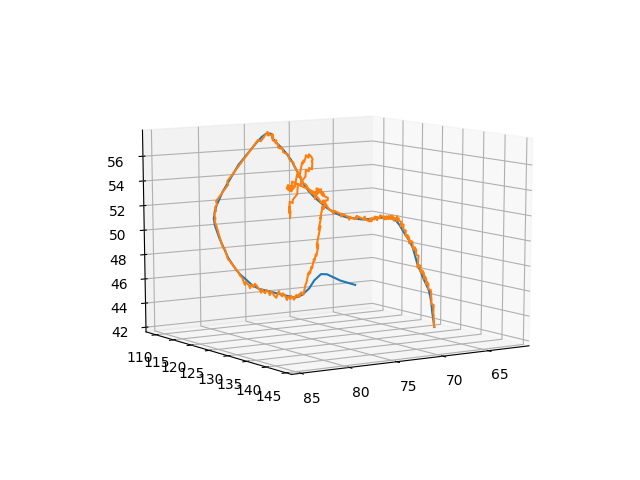

In [68]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

#for i in range(len(states)):
#    print(states[i], env.referenceStreamline_ijk[i])
#    distance = ((states.T[0][i] - env.referenceStreamline_ijk.T[0][i])**2 \
#                      + (states.T[1][i] - env.referenceStreamline_ijk.T[1][i] )**2 \
#                      + (states.T[2][i] - env.referenceStreamline_ijk.T[2][i])**2)
#    print(distance)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0][:], env.referenceStreamline_ijk.T[1][:], env.referenceStreamline_ijk.T[2][:])
ax.plot3D(states.T[0][:], states.T[1][:], states.T[2][:])
#print(optimal_steps[:])

In [67]:
states = torch.stack(all_states)
print(states.T[0][:3])

tensor([63.0359, 63.0269, 62.9113], dtype=torch.float64)


In [14]:
len(all_states)

201

In [72]:
print(referenceLine[86])

tensor([ 71.7731, 113.9662,  79.6186])


In [70]:
env.reset()
print(env.state.getCoordinate().numpy(), referenceLine[0])
step = 0
#all_rewards = []
eps_reward = 0
for i in optimal_steps:
    next_state, distance, terminal = env.step(i)
    if distance < 0.71:
        reward = 1 - distance
        #print(reward)
        if reward < 0.3:
            reward = 1
    eps_reward += reward
    #all_rewards.append(reward)
    step += 1
print(eps_reward)

[ 73.651344 107.88106   93.29415 ] tensor([ 73.6513, 107.8811,  93.2942])
tensor(66.2049, dtype=torch.float64)


In [ ]:
for i in range(n_actions):
    
    next_state, distance, terminal = env.step(i)
    

In [8]:
env.reset()
terminal = False
step = 0
actions = []
past_state = env.state
step = 1
while terminal != True:
    for i in range(n_actions)
    action = np.random.randint(n_actions)
    next_state, reward, terminal = env.step(action)
    if reward < 1:
        actions.append(action)
        past_state = next_state
        print("Action: ", action, "Step: ",step, "Coordinates: ", next_state.getCoordinate().numpy(), referenceLine[step].numpy())
        step += 1
    else:
        env.state = past_state
        env.stepCounter = step
    #action = np.random.choice(possible_actions[step])
    #next_state, reward, terminal = env.step(action)
    #step += 1

print(actions)

Action:  100 Step:  1 Coordinates:  [ 73.651344 107.88106   93.29415 ] [ 74.42344 107.87124  93.08491]
Action:  67 Step:  2 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 75.16057  107.88882   92.774536]
Action:  100 Step:  3 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 75.78847 107.96255  92.28433]
Action:  100 Step:  4 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 76.45265  108.118454  91.86654 ]
Action:  100 Step:  5 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 77.116844 108.27435   91.448746]
Action:  100 Step:  6 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 77.739716 108.54131   91.02359 ]
Action:  100 Step:  7 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 78.36259  108.80828   90.598434]
Action:  100 Step:  8 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 78.996666 109.15176   90.25207 ]
Action:  100 Step:  9 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 79.630745 109.495224  89.9057  ]
Actio

KeyboardInterrupt: 

In [16]:
print(referenceLine[6])
print(referenceLine[7])

tensor([ 77.7397, 108.5413,  91.0236])
tensor([ 78.3626, 108.8083,  90.5984])


In [11]:
state = TractographyState(torch.Tensor([ 77.8994346, 108.7020324, 90.72022516]), env.interpolateDWIatState)
for i in range(n_actions):
    env.state = state
    env.stepCounter -= 1
    next_state, _, terminal = env.step(i)
    qry_pt = next_state.getCoordinate().view(-1,3)
    distance = torch.min(torch.sum((referenceLine[7] - qry_pt)**2, dim=1))
    if distance < 0.3:
        print(i, next_state.getCoordinate().numpy(), referenceLine[7].numpy(), distance.numpy())

tensor([ 78.1077, 108.7354,  91.6977], dtype=torch.float64)
tensor([ 77.7615, 108.8643,  91.6973], dtype=torch.float64)
tensor([ 77.8808, 108.4698,  91.6927], dtype=torch.float64)
tensor([ 78.0768, 109.0850,  91.6268], dtype=torch.float64)
tensor([ 77.5148, 108.5987,  91.6375], dtype=torch.float64)
tensor([ 78.3125, 108.4477,  91.5947], dtype=torch.float64)
tensor([ 77.7489, 109.2253,  91.5590], dtype=torch.float64)
tensor([ 77.6419, 108.2420,  91.5700], dtype=torch.float64)
tensor([ 78.4297, 108.8083,  91.5614], dtype=torch.float64)
tensor([ 77.4379, 108.9717,  91.5654], dtype=torch.float64)
tensor([ 78.0813, 108.1849,  91.5566], dtype=torch.float64)
tensor([ 78.1025, 109.3932,  91.4139], dtype=torch.float64)
tensor([ 77.3094, 108.3452,  91.4445], dtype=torch.float64)
tensor([ 78.6147, 108.4838,  91.3841], dtype=torch.float64)
tensor([ 77.4417, 109.2998,  91.3783], dtype=torch.float64)
tensor([ 77.8415, 107.9787,  91.4083], dtype=torch.float64)
tensor([ 78.3907, 109.1557,  91.4638], d

In [9]:
env.reset()
next_state, reward, terminal = env.step(100)
print(next_state.getCoordinate().numpy())
print(reward)
print(terminal)

tensor(187.0214)
[ 73.651344 107.88106   93.29415 ]
-1
True


In [49]:
print(possible_actions)

[[47, 75, 80, 88, 93, 96], [67, 75, 80, 88, 93], [62, 67, 75, 80], [62, 67, 75, 80, 83], [62, 67, 75, 80, 83], [62, 67, 75, 83, 96], [62, 67, 75, 83, 96], [62, 75, 83, 91, 96], [62, 75, 83, 91, 96], [62, 75, 83, 91, 96], [62, 70, 75, 83, 91, 96], [62, 70, 75, 78, 83, 91], [54, 57, 62, 67, 70, 75, 83], [54, 62, 67, 75], [54, 59, 67, 72], [51, 54, 59, 62, 67, 72], [51, 54, 59, 64, 67, 72], [51, 54, 59, 64, 67, 72], [51, 54, 59, 64, 67, 72], [51, 54, 56, 59, 64, 67, 72], [51, 54, 56, 59, 64, 67, 72], [51, 56, 59, 64], [51, 56, 59, 64], [51, 56, 59, 64], [50, 51, 53, 56, 59], [50, 51, 53, 56, 61, 66], [53, 58, 61, 66, 74, 79], [58, 66, 71, 74, 79], [58, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79, 84], [58, 63, 71, 79, 84, 92], [58, 63, 71, 79, 84, 92], [63, 71, 79, 84, 92], [63, 71, 79, 84, 92], [38, 71, 79, 84, 92], [38, 63, 71, 84, 92, 97], [38, 71, 84, 92, 97], [38, 84, 92, 97], [38, 76, 84, 92, 97], [38, 76, 

In [8]:
env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
print(env.state.getCoordinate())
print(referenceLine[86])
print(possible_actions[85])
for i in possible_actions[85]:
    env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
    env.stepCounter = 84
    next_state, reward, _ = env.step(z)
    print(next_state.getCoordinate(), reward)

tensor([ 71.5173, 114.6476,  79.9506])
tensor([ 71.7731, 113.9662,  79.6186])
[64, 69, 77, 85, 90, 98]
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)


In [76]:
#env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
for i in range(n_actions):
    env.reset()
    env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
    next_state, reward, _ = env.step(i)
    distance = env.rewardForTerminalState(next_state)
    if distance < 0.3:
        print(referenceLine[86].numpy(), next_state.getCoordinate().numpy(), distance.item())

[ 71.773056 113.966225  79.618576] [ 72.30127204 114.02878755  79.99932066] 0.27901215525974304
[ 71.773056 113.966225  79.618576] [ 71.7609279  113.6971063   80.14330044] 0.2753356828217112
[ 71.773056 113.966225  79.618576] [ 71.37937604 113.65758474  79.97858924] 0.15498393104601757
[ 71.773056 113.966225  79.618576] [ 71.66780472 114.12438903  79.11184227] 0.2567791198339029
[ 71.773056 113.966225  79.618576] [ 71.97880832 114.37794723  79.10548775] 0.26325960220840583
[ 71.773056 113.966225  79.618576] [ 71.31423388 113.95652005  79.25698482] 0.2105177635246191
[ 71.773056 113.966225  79.618576] [ 71.97504289 114.04982978  79.29253904] 0.10630013104166292
[ 71.773056 113.966225  79.618576] [ 71.63016002 113.84417747  79.3660627 ] 0.06376299386222199
[ 71.773056 113.966225  79.618576] [ 72.24376411 114.29266559  79.36222956] 0.2215660937612901
[ 71.773056 113.966225  79.618576] [ 71.91375289 113.81268975  79.56895814] 0.023572970787664616
[ 71.773056 113.966225  79.618576] [ 71.351

In [67]:
distance = env.rewardForTerminalState(next_state)
print(referenceLine[86])
print(distance)

tensor([ 71.7731, 113.9662,  79.6186])
tensor(122.0777, dtype=torch.float64)


In [26]:
for i in range(n_actions):
    env.state = TractographyState(torch.FloatTensor([ 74.64776812, 107.9270337, 93.22325858]), env.interpolateDWIatState)
    next_state, reward, _ = env.step(i)
    env.stepCounter = 2
    if reward < 0.1:
        reward = 1
    elif reward < 0.5:
        reward = 0
    else:
        reward = -1
    if reward == 1:
        #best_actions.append(i)
        print("[{}]".format(i), referenceLine[2].numpy(), next_state.getCoordinate().numpy(), reward)
#print(best_actions)

In [ ]:
state = TractographyState(torch.FloatTensor(referenceLine[0]), env.interpolateDWIatState)
coordinates = state.getCoordinate()

In [ ]:
print(referenceLine[0])

In [ ]:
print(referenceLine[0])
print(referenceLine[70])

In [ ]:
state = TractographyState(referenceLine[69], env.interpolateDWIatState)

In [ ]:
shape = env.reset().getValue().reshape(-1).shape[0]
print(shape)

In [ ]:
state = torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)

In [ ]:
q_vals = agent.main_dqn(state)

In [ ]:
print(state.getValue().shape)
shape = state.getValue().shape
shape = np.prod(np.array(shape))
print(shape)

In [ ]:
state = TractographyState(referenceLine[70], env.interpolateDWIatState)
qry_pt = torch.FloatTensor(state.getCoordinate()).view(-1,3)
distance = torch.min(torch.sum( (referenceLine - qry_pt)**2, dim =1 ))
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance_terminal = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )

#print(distance)
#print(distance_terminal)
reward = (torch.tanh(-distance+5.3) + 2*torch.tanh(-distance_terminal+5.3))/2
print(reward)

print(torch.tanh(-distance+5.3))
print(torch.tanh(-distance_terminal+5.3))

reward += 200/20 * reward.sign()
print(reward)

In [ ]:
print(torch.tanh(-distance_terminal+5.3)+2)

In [ ]:
state = TractographyState([32., 84., 94.], env.interpolateDWIatState)
qry_pt = torch.FloatTensor(state.getCoordinate()).view(-1,3)
distance = torch.min(torch.sum( (referenceLine - qry_pt)**2, dim =1 ))
print(torch.tanh(-distance+5.3))
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )
print(-distance)
print(torch.tanh(-distance)+2)
#print(torch.where(distance < env.maxL2dist_to_terminalState, 1, 0 ))

In [ ]:
print(-1.5 + 5)

In [ ]:
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )
print(round(-distance.item(),4))

In [ ]:
print("Init agent")
#memory = ReplayMemory(size=replay_memory_size)
state = env.reset()
agent = Agent(n_actions=n_actions, inp_size=state.getValue().shape, device=device, hidden=256, agent_history_length=agent_history_length, memory_size=replay_memory_size, learning_rate=learning_rate)

print("Init epsilon-greedy action scheduler")
action_scheduler = Action_Scheduler(num_actions=n_actions, max_steps=max_steps, eps_annealing_steps=100000, replay_memory_start_size=replay_memory_size, model=agent.main_dqn)

step_counter = 0
    
eps_rewards = []

print("Start training...")
while step_counter < max_steps:
    epoch_step = 0

######## fill memory begins here
    while epoch_step < evaluate_every:  # To Do implement evaluation
        state = env.reset()
        episode_reward_sum = 0
        
        #fill replay memory while interacting with env
        for episode_counter in range(max_episode_length):
            # get action with epsilon-greedy strategy       
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).to(device).unsqueeze(0))
                    
            next_state, reward, terminal = env.step(action)

            if reward >= 1:
                reward = 10
            elif reward > -0.05:
                reward = 1
            
            if episode_counter == max_episode_length-1:
                reward = -100
                terminal = True
            # increase counter
            step_counter += 1
            epoch_step += 1

            # accumulate reward for current episode
            episode_reward_sum += reward


            agent.replay_memory.add_experience(action=action,
                                state=state.getValue(),
                                reward=reward,
                                new_state=next_state.getValue(),
                                terminal=terminal)


            state = next_state

        

            ####### optimization is happening here
            if step_counter > replay_memory_size:
                loss = agent.optimize()


            ####### target network update
            if step_counter > replay_memory_size and step_counter % network_update_every == 0:
                agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())
            
            # if episode ended before maximum step
            if terminal:
                terminal = False
                state = env.reset()
                break
                
        eps_rewards.append(episode_reward_sum)
        
        if len(eps_rewards) % 10 == 0:
            with open(path+'/logs/rewards.dat', 'a') as reward_file:
                print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])), file=reward_file)
            print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])) )
    torch.save(agent.main_dqn.state_dict(), path+'/checkpoints/fibre_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eps_rewards[-100:])))
########## evaluation starting here
    eval_rewards = []
    for _ in range(eval_runs):
        eval_steps = 0
        state = env.reset()
        eval_episode_reward = 0
        while eval_steps < max_episode_length:
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).to(device).unsqueeze(0), evaluation=True)

            next_state, reward, terminal = env.step(action)

            eval_steps += 1
            eval_episode_reward += reward
            state = next_state

            if terminal:
                terminal = False
                break

        eval_rewards.append(eval_episode_reward)
    
    print("Evaluation score:", np.mean(eval_rewards))

In [ ]:
#!mkdir -p 'checkpoints/'
#torch.save(agent.main_dqn.state_dict(), 'checkpoints/fiber_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(rewards[-100:])))